## Imports

In [ ]:
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'axes.grid': True,
    'figure.figsize': [6, 4],
})

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Dialog

In [ ]:
dial_rdcd = pd.read_parquet(f'drive/MyDrive/SberIndexTest/data/preproc/dialog_agg_8.parquet')

In [ ]:
emb_names_rdcd = ['v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7']

In [ ]:
targets = pd.read_parquet('targets')

Add targets and fit baseline

In [ ]:
trgt = 'target_label'
trgt_names = ['target_1', 'target_2', 'target_3', 'target_4']

In [ ]:
dial_targets = targets\
    .merge(dial_rdcd, on=['client_id', 'mon'], how='left')

In [143]:
dial_targets[['client_id', 'mon']].duplicated().any()

False

In [ ]:
dial_targets.head()

,client_id,mon,target_1,target_2,target_3,target_4,target_concat,target_label,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7
0,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-02-28,0,0,0,0,0000,0,-5.183194,0.460759,-1.00377,1.496838,0.098581,-0.036236,-0.2754,-0.138443
1,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-03-31,0,0,0,0,0000,0,-5.183194,0.460759,-1.00377,1.496838,0.098581,-0.036236,-0.2754,-0.138443
2,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-04-30,0,0,0,0,0000,0,-5.183194,0.460759,-1.00377,1.496838,0.098581,-0.036236,-0.2754,-0.138443
3,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-05-31,0,0,0,0,0000,0,-5.183194,0.460759,-1.00377,1.496838,0.098581,-0.036236,-0.2754,-0.138443
4,00bd0ecf3d5a33aa8756097967d07797dca4c98de9b61c...,2022-06-30,0,0,0,0,0000,0,-5.183194,0.460759,-1.00377,1.496838,0.098581,-0.036236,-0.2754,-0.138443


In [ ]:
dial_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202688 entries, 0 to 1202687
Data columns (total 16 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   client_id      1202688 non-null  object 
 1   mon            1202688 non-null  object 
 2   target_1       1202688 non-null  int32  
 3   target_2       1202688 non-null  int32  
 4   target_3       1202688 non-null  int32  
 5   target_4       1202688 non-null  int32  
 6   target_concat  1202688 non-null  object 
 7   target_label   1202688 non-null  int64  
 8   v_0            469519 non-null   float32
 9   v_1            469519 non-null   float32
 10  v_2            469519 non-null   float32
 11  v_3            469519 non-null   float32
 12  v_4            469519 non-null   float32
 13  v_5            469519 non-null   float32
 14  v_6            469519 non-null   float32
 15  v_7            469519 non-null   float32
dtypes: float32(8), int32(4), int64(1), object(3)
memory us

About 60% of observations have all missing values in all embeddings and are therefore useless for training. Nevertheless, we need to obtain predictions for all samples.  
The idea how to reach it is:
* remove all observations with missing embeddings from training sample
* at inference impute nans with mean values by column

In [102]:
from lightgbm import LGBMClassifier
import lightgbm as lgbm

from sklearn.model_selection import train_test_split

In [103]:
X = dial_targets.copy()
X = dial_targets.dropna(subset=emb_names_rdcd, how='all').copy().reset_index(drop=True)

In [104]:
X_dev, X_test = train_test_split(X, random_state=42, train_size=0.75)#, stratify=X[trgt_names])
X_train, X_valid = train_test_split(X_dev, random_state=42, train_size=0.8)#, stratify=X_dev[trgt_names])

In [105]:
X.loc[X_train.index, 'SET'] = 'train'
X.loc[X_valid.index, 'SET'] = 'valid'
X.loc[X_test.index, 'SET'] = 'test'

In [106]:
clfs = []
for i, label in enumerate(trgt_names):
    clf = LGBMClassifier(
        objective='binary',
        max_depth=4,
        n_estimators=500,
        early_stopping_rounds=10,
        importance_type='gain',
        random_state=42,
        verbose=-1,
    )
    clf.fit(
        X_train[emb_names_rdcd], X_train[label],
        eval_set=(X_valid[emb_names_rdcd], X_valid[label])
    )

    X[f'pred_{i+1}'] = clf.predict_proba(X[clf.feature_name_])[:, 1]
    clfs.append(clf)

In [115]:
from sklearn.metrics import roc_auc_score

def multi_roc_auc(x, pred_prefix='pred'):
    out = {}
    for idx, label in enumerate(trgt_names):
        out[label] = roc_auc_score(x[label], x[f"{pred_prefix}_{idx+1}"])
    return pd.Series(out)

In [108]:
X\
    .groupby('SET')\
    .apply(multi_roc_auc)\
    .loc[['train', 'valid','test']]

<ipython-input-108-fd48df600f3e>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(multi_roc_auc)\


,target_1,target_2,target_3,target_4
SET,,,,
train,0.522847,0.567858,0.674055,0.674213
valid,0.479920,0.526258,0.551042,0.520452
test,0.488221,0.466581,0.539036,0.570033


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

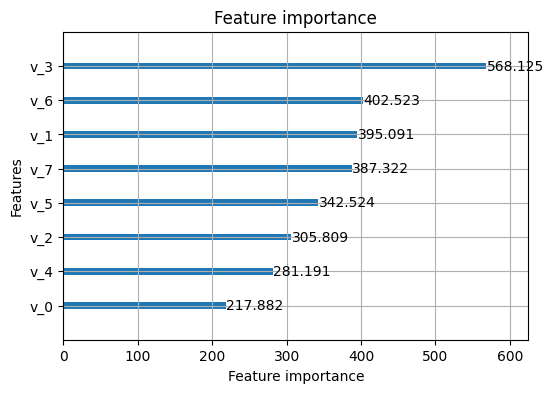

In [20]:
lgbm.plot_importance(clf)

Model inference for all samples

In [110]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [113]:
X_to_score = dial_targets.copy()
X_to_score[emb_names_rdcd] = imp.fit_transform(X_to_score[emb_names_rdcd])

In [116]:
for i, label in enumerate(trgt_names):
    clf = clfs[i]
    X_to_score[f'pred_dial_{i+1}'] = clf.predict_proba(X_to_score[clf.feature_name_])[:, 1]

In [25]:
multi_roc_auc(X_to_score, pred_prefix='pred_dial')

,0
target_1,0.552547
target_2,0.620959
target_3,0.597193
target_4,0.629540


In [118]:
X_to_score[['client_id', 'mon', *trgt_names, 'pred_dial_1', 'pred_dial_2', 'pred_dial_3', 'pred_dial_4']].to_parquet('data_scored_dial.parquet')

## Transaction aggregates

In [119]:
trx_agg = pd.read_parquet('drive/MyDrive/SberIndexTest/data/preproc/trx_agg')

In [120]:
trx_targets = targets\
    .merge(trx_agg , on=['client_id', 'mon'], how='left')

In [142]:
trx_targets[['client_id', 'mon']].duplicated().any()

True

In [144]:
trx_targets.drop_duplicates(subset=['client_id', 'mon'], inplace=True)

In [145]:
trx_names = [x for x in trx_targets.columns if x.startswith('trx_')]
cat_cols = ['trx_src22_mode', 'trx_src32_mode']

A client has no transactions in time period => fill aggregates with NaNs

In [146]:
trx_targets.loc[trx_targets['trx_cnt_1m'] == 0, ['trx_sum_1m', 'trx_max_1m']] = np.nan
trx_targets.loc[trx_targets['trx_cnt_3m'] == 0, ['trx_sum_3m', 'trx_max_3m']] = np.nan
trx_targets.loc[trx_targets['trx_cnt_6m'] == 0, ['trx_sum_6m', 'trx_max_6m']] = np.nan

In [45]:
trx_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202688 entries, 0 to 1202687
Data columns (total 22 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   client_id        1202688 non-null  object  
 1   mon              1202688 non-null  object  
 2   target_1         1202688 non-null  int32   
 3   target_2         1202688 non-null  int32   
 4   target_3         1202688 non-null  int32   
 5   target_4         1202688 non-null  int32   
 6   trans_count      1202688 non-null  int32   
 7   diff_trans_date  1081902 non-null  float64 
 8   fold             1202688 non-null  category
 9   trx_cnt_1m       1125834 non-null  float64 
 10  trx_sum_1m       982201 non-null   float64 
 11  trx_max_1m       982201 non-null   float32 
 12  trx_cnt_3m       1125834 non-null  float64 
 13  trx_sum_3m       1041091 non-null  float64 
 14  trx_max_3m       1041091 non-null  float32 
 15  trx_cnt_6m       1125834 non-null  float64 
 16  

At training stage replace samples that have all aggregates missing

In [148]:
X_trx = trx_targets\
    .dropna(subset=trx_names, how='all')\
    .copy()

In [47]:
X_trx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1125834 entries, 0 to 1202687
Data columns (total 22 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   client_id        1125834 non-null  object  
 1   mon              1125834 non-null  object  
 2   target_1         1125834 non-null  int32   
 3   target_2         1125834 non-null  int32   
 4   target_3         1125834 non-null  int32   
 5   target_4         1125834 non-null  int32   
 6   trans_count      1125834 non-null  int32   
 7   diff_trans_date  1070524 non-null  float64 
 8   fold             1125834 non-null  category
 9   trx_cnt_1m       1125834 non-null  float64 
 10  trx_sum_1m       982201 non-null   float64 
 11  trx_max_1m       982201 non-null   float32 
 12  trx_cnt_3m       1125834 non-null  float64 
 13  trx_sum_3m       1041091 non-null  float64 
 14  trx_max_3m       1041091 non-null  float32 
 15  trx_cnt_6m       1125834 non-null  float64 
 16  trx_s

Impute remaining missing values with mean by columns

In [150]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_trx[trx_names] = imp.fit_transform(X_trx[trx_names])

In [151]:
X_trx[cat_cols] = X_trx[cat_cols].astype('category')

In [152]:
X_trx_dev, X_trx_test = train_test_split(X_trx, random_state=42, train_size=0.75)
X_trx_train, X_trx_valid = train_test_split(X_trx_dev, random_state=42, train_size=0.8)

In [153]:
X_trx.loc[X_trx_train.index, 'SET'] = 'train'
X_trx.loc[X_trx_valid.index, 'SET'] = 'valid'
X_trx.loc[X_trx_test.index, 'SET'] = 'test'

In [154]:
clfs_trx = []
for i, label in enumerate(trgt_names):
    clf = LGBMClassifier(
        objective='binary',
        max_depth=4,
        n_estimators=500,
        early_stopping_rounds=10,
        importance_type='gain',
        random_state=42,
        verbose=-1,
        categorical_feature=cat_cols
    )
    clf.fit(
        X_trx_train[trx_names], X_trx_train[label],
        eval_set=(X_trx_valid[trx_names], X_trx_valid[label])
    )

    X_trx[f'pred_{i+1}'] = clf.predict_proba(X_trx[clf.feature_name_])[:, 1]
    clfs_trx.append(clf)

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

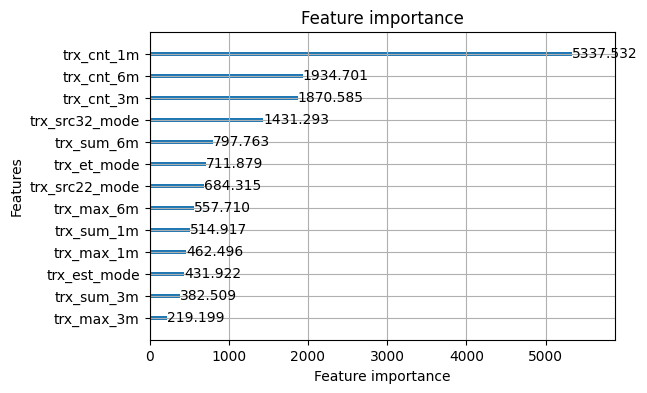

In [53]:
lgbm.plot_importance(clf)

In [156]:
X_trx\
    .groupby('SET')\
    .apply(multi_roc_auc)\
    .loc[['train', 'valid','test']]

<ipython-input-156-2e8d91efeb84>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(multi_roc_auc)\


,target_1,target_2,target_3,target_4
SET,,,,
train,0.814179,0.867687,0.822513,0.818182
valid,0.775580,0.819181,0.799354,0.755539
test,0.785082,0.837107,0.797992,0.753786


Analyze ROC-AUC dynamics over months

In [157]:
X_trx\
    .groupby('mon')\
    .apply(lambda x: roc_auc_score(x['target_1'], x['pred_1']))

<ipython-input-157-fa316c3b4e6a>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: roc_auc_score(x['target_1'], x['pred_1']))


,0
mon,
2022-02-28,0.779064
2022-03-31,0.787956
2022-04-30,0.804866
2022-05-31,0.789611
2022-06-30,0.820444
2022-07-31,0.819084
2022-08-31,0.797184
2022-09-30,0.778530
2022-10-31,0.801776


In [189]:
trx_targets\
    .dropna(subset=trx_names, how='all')\
    .groupby('mon')\
    .apply(lambda x: x[['trx_sum_1m', 'trx_sum_3m', 'trx_sum_6m']].isna().mean())

<ipython-input-189-39ce9f83811f>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x[['trx_sum_1m', 'trx_sum_3m', 'trx_sum_6m']].isna().mean())


,trx_sum_1m,trx_sum_3m,trx_sum_6m
mon,,,
2022-02-28,0.140790,0.060664,0.029371
2022-03-31,0.142774,0.065089,0.029865
2022-04-30,0.151713,0.070109,0.031207
2022-05-31,0.161589,0.074455,0.030816
2022-06-30,0.165154,0.081504,0.032430
2022-07-31,0.168669,0.089292,0.036075
2022-08-31,0.186679,0.095885,0.041824
2022-09-30,0.189430,0.100997,0.048253
2022-10-31,0.190402,0.111356,0.055316


Scoring

In [159]:
X_trx_out = trx_targets.copy()
X_trx_out[trx_names] = imp.transform(X_trx_out[trx_names])
X_trx_out[cat_cols] = X_trx_out[cat_cols].astype('category')

In [160]:
for i, label in enumerate(trgt_names):
    X_trx_out[f'pred_trx_{i+1}'] = clf.predict_proba(X_trx_out[clf.feature_name_])[:, 1]

In [161]:
multi_roc_auc(X_trx_out, pred_prefix='pred_trx')

,0
target_1,0.721359
target_2,0.768324
target_3,0.759974
target_4,0.789085


In [162]:
X_trx_out[['client_id', 'mon', 'pred_trx_1', 'pred_trx_2', 'pred_trx_3', 'pred_trx_4']].to_parquet('data_scored_trx.parquet')


## Final calibration

* Take predicted probabilities from both domain models
* Map them into score space via inverse sigmoid
* Train logreg on two scores
* Repeat for each target

In [63]:
X_final = X_to_score[['client_id', 'mon', *trgt_names, 'pred_dial_1', 'pred_dial_2', 'pred_dial_3', 'pred_dial_4']]\
    .merge(X_trx_out[['client_id', 'mon', 'pred_trx_1', 'pred_trx_2', 'pred_trx_3', 'pred_trx_4']], on=['client_id', 'mon'])

In [64]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1202688 entries, 0 to 1202687
Data columns (total 14 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   client_id    1202688 non-null  object 
 1   mon          1202688 non-null  object 
 2   target_1     1202688 non-null  int32  
 3   target_2     1202688 non-null  int32  
 4   target_3     1202688 non-null  int32  
 5   target_4     1202688 non-null  int32  
 6   pred_dial_1  1202688 non-null  float64
 7   pred_dial_2  1202688 non-null  float64
 8   pred_dial_3  1202688 non-null  float64
 9   pred_dial_4  1202688 non-null  float64
 10  pred_trx_1   1202688 non-null  float64
 11  pred_trx_2   1202688 non-null  float64
 12  pred_trx_3   1202688 non-null  float64
 13  pred_trx_4   1202688 non-null  float64
dtypes: float64(8), int32(4), object(2)
memory usage: 110.1+ MB


In [65]:
train_fin, test_fin = train_test_split(X_final, random_state=42, train_size=0.8)

In [66]:
def sigmoid_inv(x):
    return np.log(x / (1 - x))

In [67]:
from sklearn.linear_model import LogisticRegression

In [68]:
for idx in range(1, 5):
    pred_dial = f"pred_dial_{i}"
    pred_trx = f"pred_trx_{i}"
    trgt = f"target_{i}"

    train_score = sigmoid_inv(train_fin[[pred_dial, pred_trx]])
    X_score = sigmoid_inv(X_final[[pred_dial, pred_trx]])

    lr = LogisticRegression(random_state=42)
    lr.fit(train_score, train_fin[trgt])

    X_final[f'pred_final_{idx}'] = lr.predict_proba(X_score)[:, 1]

In [69]:
roc_auc_final = multi_roc_auc(X_final, pred_prefix='pred_final')

In [70]:
roc_auc_final

,0
target_1,0.703087
target_2,0.798569
target_3,0.805747
target_4,0.731945


In [71]:
l = roc_auc_final.std() / np.sqrt(4) * 1.96

In [72]:
print('Final ROC-AUC')
print(f"{roc_auc_final.mean():.2}+-{l:.2}")

Final ROC-AUC
0.76+-0.049
